**Original ORSO as per existing paper**

In [ ]:
#Forming class 'Olive Ridley Survival Optimizer'
import numpy as np
class OliveRidleySurvivalOptimizer:
    def __init__(self, objective_function, num_turtles=30, dimensions=2, lower_bound=-100, upper_bound=100,
                 max_iterations=100, tolerable_temp=28, max_temp=35, time_range=(6, 18)):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        # Initialize turtle positions and velocities
        self.turtles = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions)).astype(np.float64)
        self.velocities = np.random.uniform(-1, 1, (num_turtles, dimensions)).astype(np.float64)

        self.best_turtle = None
        self.best_fitness = float("inf")

        # Biological parameters
        self.sand_temperature = np.random.uniform(25, 38, num_turtles).astype(np.float64)
        self.time_of_day = np.random.uniform(0, 24, num_turtles).astype(np.float64)
        self.emergence_types = np.random.choice([-1, 0, 1], num_turtles).astype(np.float64)

        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

        self.convergence = []

    def temperature_impact(self, temp):
        """ Linear speed adjustment based on temperature """
        if temp < self.tolerable_temp:
            return 1 + 0.1 * (self.tolerable_temp - temp)  # Linear increase
        elif self.tolerable_temp <= temp <= self.max_temp:
            return 1 - 0.1 * (temp - self.tolerable_temp)  # Linear decrease
        else:
            return -np.inf  # Turtle dies

    def time_of_day_impact(self, time):
        return 1.5 if self.time_range[0] <= time <= self.time_range[1] else 0.5

    def emergence_impact(self, emergence_type):
        return emergence_type  # Early (+1), Middle (0), Late (-1)

    def optimize(self):
        for iteration in range(self.max_iterations):
            fitness_values = np.apply_along_axis(self.obj_func, 1, self.turtles)

            min_index = np.argmin(fitness_values)
            if fitness_values[min_index] < self.best_fitness:
                self.best_fitness = fitness_values[min_index]
                self.best_turtle = self.turtles[min_index].copy()

            self.convergence.append(self.best_fitness)

            # Exploration
            random_factor = np.random.uniform(0, 1, (self.num_turtles, self.dimensions))
            movement_direction = np.sign(np.random.uniform(-1, 1, (self.num_turtles, self.dimensions)))
            exploration_step = (1 - iteration / self.max_iterations) * movement_direction * random_factor
            self.turtles += exploration_step

            new_velocities = np.zeros((self.num_turtles, self.dimensions))

            for i in range(self.num_turtles):
                temp_factor = np.float64(self.temperature_impact(self.sand_temperature[i]))
                time_factor = np.float64(self.time_of_day_impact(self.time_of_day[i]))
                efk = np.random.rand()
                emergence_factor = np.float64(self.emergence_impact(self.emergence_types[i]) * efk)

                if temp_factor == -np.inf:
                    fitness_values[i] = np.inf
                    continue

                velocity_change_temp = self.velocities[i] * temp_factor
                velocity_change_time = self.velocities[i] * time_factor
                velocity_change_emergence = emergence_factor

                new_velocities[i] = velocity_change_temp + velocity_change_time + velocity_change_emergence

            self.velocities = new_velocities
            self.turtles += self.velocities
            self.turtles = np.clip(self.turtles, self.lower_bound, self.upper_bound)

            #if (iteration + 1) % 100 == 0:
                #print(f"Iteration {iteration + 1}, Best Fitness: {self.best_fitness}")

        return self.best_turtle, self.best_fitness, self.convergence

In [ ]:
# Example Usage
def sphere_function(x):
  return np.sum(x**2)  # Sphere function (min at x = 0)

In [ ]:
# Run ORSO
for i in range(5):
  orso = OliveRidleySurvivalOptimizer(objective_function=sphere_function, dimensions=5, max_iterations=500)
  best_solution, best_fitness,convergence = orso.optimize()
  print("\nBest Solution:", best_solution)
  print("Best Fitness:", best_fitness)
  print("Convergence",convergence)
  print()


Best Solution: [ 47.73452203  34.5506557   40.79004737 -17.62708021 -30.91442056]
Best Fitness: 6402.57572185308
Convergence [np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.float64(6402.57572185308), np.

**Variation 1 (BEST) Bio hybrid ORSO**


1. Temp effect is exponential to speed
2. Time of day acts is sigmoid
3. Emergence is momentum
4. Turtles follow global best solution
5. Only random exploitation kept same , rest linears are changed to above



In [ ]:
#Variation 1
class ModifiedOliveRidleySurvivalOptimizer:
    def __init__(self, objective_function, num_turtles=30, dimensions=5, lower_bound=-100, upper_bound=100,
                 max_iterations=500, tolerable_temp=28, max_temp=35, time_range=(6, 18),
                 beta=0.6, learning_rate=0.05):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        self.beta = beta
        self.learning_rate = learning_rate

        self.positions = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions))
        self.velocities = np.random.uniform(-1, 1, (num_turtles, dimensions))

        self.best_score = float("inf")
        self.best_position = None

        self.temperatures = np.random.uniform(25, 38, num_turtles)
        self.times = np.random.uniform(0, 24, num_turtles)
        self.emergence = np.random.choice([-1, 0, 1], num_turtles)

        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

    def temperature_impact(self, temp):
        if temp < self.tolerable_temp:
            return 1 + np.exp(-0.1 * (self.tolerable_temp - temp))
        elif self.tolerable_temp <= temp <= self.max_temp:
            return np.exp(-0.1 * (temp - self.tolerable_temp))
        else:
            return -np.inf

    def time_of_day_impact(self, t):
        midpoint = (self.time_range[0] + self.time_range[1]) / 2
        steepness = 0.5
        return 1 / (1 + np.exp(-steepness * (t - midpoint))) + 0.5

    def emergence_impact(self, e):
        return 1.0 + 0.2 * e

    def optimize(self):
        convergence = []

        for iteration in range(self.max_iterations):
            fitness = np.apply_along_axis(self.obj_func, 1, self.positions)
            min_idx = np.argmin(fitness)

            if fitness[min_idx] < self.best_score:
                self.best_score = fitness[min_idx]
                self.best_position = self.positions[min_idx].copy()

            convergence.append(self.best_score)

            exploration_decay = 1.0 - iteration / self.max_iterations
            random_noise = exploration_decay * np.random.uniform(-1, 1, (self.num_turtles, self.dimensions))
            self.positions += random_noise

            for i in range(self.num_turtles):
                temp = self.temperature_impact(self.temperatures[i])
                time = self.time_of_day_impact(self.times[i])
                emerge = self.emergence_impact(self.emergence[i])

                if temp == -np.inf:
                    fitness[i] = np.inf
                    continue

                bio_influence = temp * time * emerge
                cognitive_component = np.random.rand(self.dimensions) * (self.best_position - self.positions[i])
                velocity_update = self.beta * self.velocities[i] + (1 - self.beta) * cognitive_component
                velocity_update *= bio_influence

                self.velocities[i] = velocity_update
                self.positions[i] += velocity_update

            self.positions = np.clip(self.positions, self.lower_bound, self.upper_bound)

            imp_rate = abs(self.best_score - np.min(fitness)) / (abs(self.best_score) + 1e-8)
            self.beta = max(0.3, min(0.9, self.beta * (1 - self.learning_rate * imp_rate)))

            #if (iteration + 1) % 100 == 0:
                #print(f"Iteration {iteration+1} | Best Fitness: {self.best_score:.4f} | β: {self.beta:.3f}")

        return self.best_position, self.best_score, convergence

In [ ]:
def sphere_function(x):
  return np.sum(x**2)  # Sphere function (min at x = 0)

In [ ]:
# Run ORSO
convfull=[]
for i in range(5):
  morso = ModifiedOliveRidleySurvivalOptimizer(objective_function=sphere_function, dimensions=5, max_iterations=500)
  best_solution, best_fitness,convergence = morso.optimize()
  print("\nBest Solution:", best_solution)
  print("Best Fitness:", best_fitness)
  convfull.append(convergence)
  print()


Best Solution: [-0.00270452  0.00032166 -0.00223879 -0.0015964  -0.00043797]
Best Fitness: 1.5170380982413302e-05


Best Solution: [-0.00129855 -0.00089033 -0.0023663  -0.00064711  0.00020148]
Best Fitness: 8.53762817824726e-06


Best Solution: [ 0.001159   -0.0013977  -0.00088685  0.00187999  0.00507176]
Best Fitness: 3.334047157077588e-05


Best Solution: [-0.00039172 -0.00296106 -0.0008172  -0.00203802  0.00227108]
Best Fitness: 1.890051574536258e-05


Best Solution: [-0.0014532  -0.00185495  0.00072565  0.0006246  -0.00085807]
Best Fitness: 7.2056413819445164e-06



**Variation 2 : Original but with adaptive learning rate.**

In [ ]:
class ModifiedOliveRidleySurvivalOptimizer_2:
    def __init__(self, objective_function, num_turtles=30, dimensions=2, lower_bound=-100, upper_bound=100,
                 max_iterations=100, tolerable_temp=28, max_temp=35, time_range=(6, 18), beta=0.5, learning_rate=0.1):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        # Adaptive Beta
        self.beta = beta
        self.learning_rate = learning_rate

        # Initialize turtle positions and velocities
        self.turtles = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions)).astype(np.float64)
        self.velocities = np.random.uniform(-1, 1, (num_turtles, dimensions)).astype(np.float64)

        self.best_turtle = None
        self.best_fitness = float("inf")

        # Biological parameters
        self.sand_temperature = np.random.uniform(25, 38, num_turtles).astype(np.float64)
        self.time_of_day = np.random.uniform(0, 24, num_turtles).astype(np.float64)
        self.emergence_types = np.random.choice([-1, 0, 1], num_turtles).astype(np.float64)

        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

    def temperature_impact(self, temp):
        if temp < self.tolerable_temp:
            return 1 + np.exp(-0.1 * (self.tolerable_temp - temp))
        elif self.tolerable_temp <= temp <= self.max_temp:
            return np.exp(-0.1 * (temp - self.tolerable_temp))
        else:
            return -np.inf

    def time_of_day_impact(self, time):
        return 1.5 if self.time_range[0] <= time <= self.time_range[1] else 0.5

    def emergence_impact(self, emergence_type):
        return emergence_type

    def optimize(self):
        convergence=[]
        for iteration in range(self.max_iterations):
            fitness_values = np.apply_along_axis(self.obj_func, 1, self.turtles)

            min_index = np.argmin(fitness_values)
            if fitness_values[min_index] < self.best_fitness:
                self.best_fitness = fitness_values[min_index]
                self.best_turtle = self.turtles[min_index].copy()
            convergence.append(self.best_fitness)

            random_factor = np.random.uniform(0, 1, (self.num_turtles, self.dimensions))
            movement_direction = np.sign(np.random.uniform(-1, 1, (self.num_turtles, self.dimensions)))
            exploration_step = (1 - self.beta) * movement_direction * random_factor
            self.turtles += exploration_step

            new_velocities = np.zeros((self.num_turtles, self.dimensions))

            for i in range(self.num_turtles):
                temp_factor = self.temperature_impact(self.sand_temperature[i])
                time_factor = self.time_of_day_impact(self.time_of_day[i])
                emergence_factor = self.emergence_impact(self.emergence_types[i])

                if temp_factor == -np.inf:
                    fitness_values[i] = np.inf
                    continue

                velocity_change_temp = self.velocities[i] * temp_factor
                velocity_change_time = self.velocities[i] * time_factor
                velocity_change_emergence = self.velocities[i] * emergence_factor

                #new_velocities[i] = (self.beta * (velocity_change_temp + velocity_change_time) + (0.5+0.5*(1 - self.beta)) * velocity_change_emergence)
                new_velocities[i] = (self.beta * (velocity_change_temp + velocity_change_time) + (self.beta) * velocity_change_emergence)

            self.velocities = new_velocities
            self.turtles += self.velocities
            self.turtles = np.clip(self.turtles, self.lower_bound, self.upper_bound)

            improvement_rate = abs(self.best_fitness - np.min(fitness_values)) / (abs(self.best_fitness) + 1e-8)
            self.beta = max(0.1, min(0.9, self.beta * (1 - self.learning_rate * improvement_rate)))

            #if (iteration + 1) % 100 == 0:
                #print(f"Iteration {iteration + 1}, Best Fitness: {self.best_fitness}, Beta: {self.beta:.2f}")

        return self.best_turtle, self.best_fitness,convergence


def sphere_function(x):
    return np.sum(x**2)  # Sphere function (min at x = 0)


# Run ORSO
convfull=[]
for i in range(5):
  orso = ModifiedOliveRidleySurvivalOptimizer_2(objective_function=sphere_function, dimensions=5, max_iterations=500)
  best_solution, best_fitness,convergence = orso.optimize()
  print("\nBest Solution:", best_solution)
  print("Best Fitness:", best_fitness)
  convfull.append(convergence)
  print()


Best Solution: [-17.03426632  12.99625917  -1.90527449  -5.82413997  -8.38247825]
Best Fitness: 566.8856004187388


Best Solution: [-30.93599839 -29.35431063  24.95955039  -8.44290516  -0.69993547]
Best Fitness: 2513.463261826557


Best Solution: [ 16.54253885 -15.04448314  25.13970543  11.29372538  19.04289777]
Best Fitness: 1622.1770418801186


Best Solution: [-33.50819755 -49.42848127 -16.81920299  15.99343799   9.09201312]
Best Fitness: 4187.314414177942


Best Solution: [-20.22582631 -39.18403085 -28.63803607 -27.86298978  42.16935082]
Best Fitness: 5319.209781592641



**Variation 3: Realistic exploration phase but without global best and adaptive velocity use**

In [ ]:
class ModifiedOliveRidleySurvivalOptimizer_3:
    def __init__(self, objective_function, num_turtles=30, dimensions=2, lower_bound=-100, upper_bound=100,
                 max_iterations=100, tolerable_temp=28, max_temp=35, time_range=(6, 18)):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        # Positions
        self.turtles = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions))
        self.best_turtle = None
        self.best_fitness = float("inf")

        # Biological Factors
        self.sand_temperature = np.random.uniform(25, 38, num_turtles)
        self.time_of_day = np.random.uniform(0, 24, num_turtles)
        self.emergence_types = np.random.choice([-1, 0, 1], num_turtles)

        # Constants
        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

    def temperature_impact(self, temp):
        if temp < self.tolerable_temp:
            return 1 + np.exp(-0.1 * (self.tolerable_temp - temp))
        elif self.tolerable_temp <= temp <= self.max_temp:
            return np.exp(-0.1 * (temp - self.tolerable_temp))
        else:
            return -np.inf

    def time_of_day_impact(self, time):
        return 1.5 if self.time_range[0] <= time <= self.time_range[1] else 0.5

    def emergence_impact(self, emergence_type):
        return emergence_type

    def optimize(self):
        for iteration in range(self.max_iterations):
            fitness_values = np.apply_along_axis(self.obj_func, 1, self.turtles)
            min_idx = np.argmin(fitness_values)
            if fitness_values[min_idx] < self.best_fitness:
                self.best_fitness = fitness_values[min_idx]
                self.best_turtle = self.turtles[min_idx].copy()

            # Exploration: biologically driven position update
            for i in range(self.num_turtles):
                temp_factor = self.temperature_impact(self.sand_temperature[i])
                if temp_factor == -np.inf:
                    continue  # Dead turtle

                time_factor = self.time_of_day_impact(self.time_of_day[i])
                emergence_factor = self.emergence_impact(self.emergence_types[i]) * np.random.rand()

                # Biological movement
                random_walk = np.random.uniform(-1, 1, self.dimensions)
                total_biological_effect = (temp_factor + time_factor + emergence_factor) * random_walk
                self.turtles[i] += total_biological_effect

            self.turtles = np.clip(self.turtles, self.lower_bound, self.upper_bound)

        return self.best_turtle, self.best_fitness

# Example
def sphere(x): return np.sum(x**2)

orso_bio = ModifiedOliveRidleySurvivalOptimizer_3(objective_function=sphere, dimensions=5, max_iterations=500)
sol, fit = orso_bio.optimize()
print("Best:", sol, "\nFitness:", fit)

Best: [  8.05311331  36.10138622  12.26793491 -34.27512632  22.27414882] 
Fitness: 3189.5869378756465


**Variation 4: Bio hybrid ORS but temperature effect is linear**

In [ ]:
class ModifiedOliveRidleySurvivalOptimizer_4:
    def __init__(self, objective_function, num_turtles=30, dimensions=2, lower_bound=-100, upper_bound=100,
                 max_iterations=100, tolerable_temp=28, max_temp=35, time_range=(6, 18), beta=0.5, learning_rate=0.1):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        self.beta = beta
        self.learning_rate = learning_rate

        self.turtles = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions))
        self.velocities = np.random.uniform(-1, 1, (num_turtles, dimensions))

        self.best_turtle = None
        self.best_fitness = float("inf")

        self.sand_temperature = np.random.uniform(25, 38, num_turtles)
        self.time_of_day = np.random.uniform(0, 24, num_turtles)
        self.emergence_types = np.random.choice([-1, 0, 1], num_turtles)

        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

    def temperature_impact(self, temp):
        if temp < self.tolerable_temp:
            return 1 + (self.tolerable_temp - temp) / self.tolerable_temp
        elif self.tolerable_temp <= temp <= self.max_temp:
            return 1 - (temp - self.tolerable_temp) / (self.max_temp - self.tolerable_temp)
        else:
            return -np.inf

    def time_of_day_impact(self, time):
        return 1.5 if self.time_range[0] <= time <= self.time_range[1] else 0.5

    def emergence_impact(self, emergence_type):
        return emergence_type

    def optimize(self):
        convergence = []

        for iteration in range(self.max_iterations):
            fitness_values = np.apply_along_axis(self.obj_func, 1, self.turtles)

            min_index = np.argmin(fitness_values)
            if fitness_values[min_index] < self.best_fitness:
                self.best_fitness = fitness_values[min_index]
                self.best_turtle = self.turtles[min_index].copy()
            convergence.append(self.best_fitness)

            exploration_noise = np.random.uniform(-1, 1, (self.num_turtles, self.dimensions))
            exploration_step = (1 - self.beta) * exploration_noise
            self.turtles += exploration_step

            new_velocities = np.zeros_like(self.velocities)

            for i in range(self.num_turtles):
                temp_factor = self.temperature_impact(self.sand_temperature[i])
                time_factor = self.time_of_day_impact(self.time_of_day[i])
                emergence_factor = self.emergence_impact(self.emergence_types[i])

                if temp_factor == -np.inf:
                    fitness_values[i] = np.inf
                    continue

                velocity_change_temp = self.velocities[i] * temp_factor
                velocity_change_time = self.velocities[i] * time_factor
                velocity_change_emergence = self.velocities[i] * emergence_factor

                new_velocities[i] = (self.beta * (velocity_change_temp + velocity_change_time) +
                                     self.beta * velocity_change_emergence)

            self.velocities = new_velocities
            self.turtles += self.velocities
            self.turtles = np.clip(self.turtles, self.lower_bound, self.upper_bound)

            improvement_rate = abs(self.best_fitness - np.min(fitness_values)) / (abs(self.best_fitness) + 1e-8)
            self.beta = max(0.1, min(0.9, self.beta * (1 - self.learning_rate * improvement_rate)))

            #if (iteration + 1) % 100 == 0:
                #print(f"Iteration {iteration + 1}, Best Fitness: {self.best_fitness:.4f}, Beta: {self.beta:.2f}")

        return self.best_turtle, self.best_fitness, convergence


# Test the new version
def sphere(x):
    return np.sum(x**2)

conv_all = []
for i in range(3):  # Fewer runs for testing
    orso = ModifiedOliveRidleySurvivalOptimizer_4(objective_function=sphere, dimensions=5, max_iterations=300)
    sol, fitness, conv = orso.optimize()
    print(f"\nRun {i+1}: Best Fitness = {fitness:.4f}")
    conv_all.append(conv)


Run 1: Best Fitness = 3812.2288

Run 2: Best Fitness = 5590.5260

Run 3: Best Fitness = 2935.9772


**Variation 5: Bio hybrid ORS but emergence effect is same as original ( -1, 0, 1 )**

In [ ]:
class ModifiedOliveRidleySurvivalOptimizer_5:
    def __init__(self, objective_function, num_turtles=30, dimensions=2, lower_bound=-100, upper_bound=100,
                 max_iterations=100, tolerable_temp=28, max_temp=35, time_range=(6, 18), beta=0.5, learning_rate=0.1):
        self.obj_func = objective_function
        self.num_turtles = num_turtles
        self.dimensions = dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.max_iterations = max_iterations

        self.beta = beta
        self.learning_rate = learning_rate

        self.turtles = np.random.uniform(lower_bound, upper_bound, (num_turtles, dimensions))
        self.velocities = np.random.uniform(-1, 1, (num_turtles, dimensions))

        self.best_turtle = None
        self.best_fitness = float("inf")

        self.sand_temperature = np.random.uniform(25, 38, num_turtles)
        self.time_of_day = np.random.uniform(0, 24, num_turtles)
        self.emergence_times = np.sort(np.random.rand(num_turtles))  # Simulated emergence timestamps

        self.tolerable_temp = tolerable_temp
        self.max_temp = max_temp
        self.time_range = time_range

    def temperature_impact(self, temp):
        if temp < self.tolerable_temp:
            return np.exp((self.tolerable_temp - temp) / self.tolerable_temp)
        elif self.tolerable_temp <= temp <= self.max_temp:
            return np.exp(-(temp - self.tolerable_temp) / (self.max_temp - self.tolerable_temp + 1e-8))
        else:
            return -np.inf

    def time_of_day_impact(self, time):
        return 1.5 if self.time_range[0] <= time <= self.time_range[1] else 0.5

    def emergence_impact(self, emergence_rank):
        # Normalize between -1 (latest) and +1 (earliest)
        return 1.0 - 2.0 * emergence_rank  # earliest = 0 ⇒ +1, latest = 1 ⇒ -1

    def optimize(self):
        convergence = []

        for iteration in range(self.max_iterations):
            fitness_values = np.apply_along_axis(self.obj_func, 1, self.turtles)

            min_index = np.argmin(fitness_values)
            if fitness_values[min_index] < self.best_fitness:
                self.best_fitness = fitness_values[min_index]
                self.best_turtle = self.turtles[min_index].copy()
            convergence.append(self.best_fitness)

            exploration_noise = np.random.uniform(-1, 1, (self.num_turtles, self.dimensions))
            exploration_step = (1 - self.beta) * exploration_noise
            self.turtles += exploration_step

            new_velocities = np.zeros_like(self.velocities)

            emergence_ranks = np.argsort(np.argsort(self.emergence_times)) / (self.num_turtles - 1)

            for i in range(self.num_turtles):
                temp_factor = self.temperature_impact(self.sand_temperature[i])
                time_factor = self.time_of_day_impact(self.time_of_day[i])
                emergence_factor = self.emergence_impact(emergence_ranks[i])

                if temp_factor == -np.inf:
                    fitness_values[i] = np.inf
                    continue

                velocity_change_temp = self.velocities[i] * temp_factor
                velocity_change_time = self.velocities[i] * time_factor
                velocity_change_emergence = self.velocities[i] * emergence_factor

                new_velocities[i] = (self.beta * (velocity_change_temp + velocity_change_time) +
                                     self.beta * velocity_change_emergence)

            self.velocities = new_velocities
            self.turtles += self.velocities
            self.turtles = np.clip(self.turtles, self.lower_bound, self.upper_bound)

            improvement_rate = abs(self.best_fitness - np.min(fitness_values)) / (abs(self.best_fitness) + 1e-8)
            self.beta = max(0.1, min(0.9, self.beta * (1 - self.learning_rate * improvement_rate)))

            #if (iteration + 1) % 100 == 0:
                #print(f"Iteration {iteration + 1}, Best Fitness: {self.best_fitness:.4f}, Beta: {self.beta:.2f}")

        return self.best_turtle, self.best_fitness, convergence


# Example
def sphere(x):
    return np.sum(x**2)

conv_all = []
for i in range(3):
    orso = ModifiedOliveRidleySurvivalOptimizer_5(objective_function=sphere, dimensions=5, max_iterations=300)
    sol, fitness, conv = orso.optimize()
    print(f"\nRun {i+1}: Best Fitness = {fitness:.4f}")
    conv_all.append(conv)


Run 1: Best Fitness = 5622.1508

Run 2: Best Fitness = 1936.2406

Run 3: Best Fitness = 3501.8619


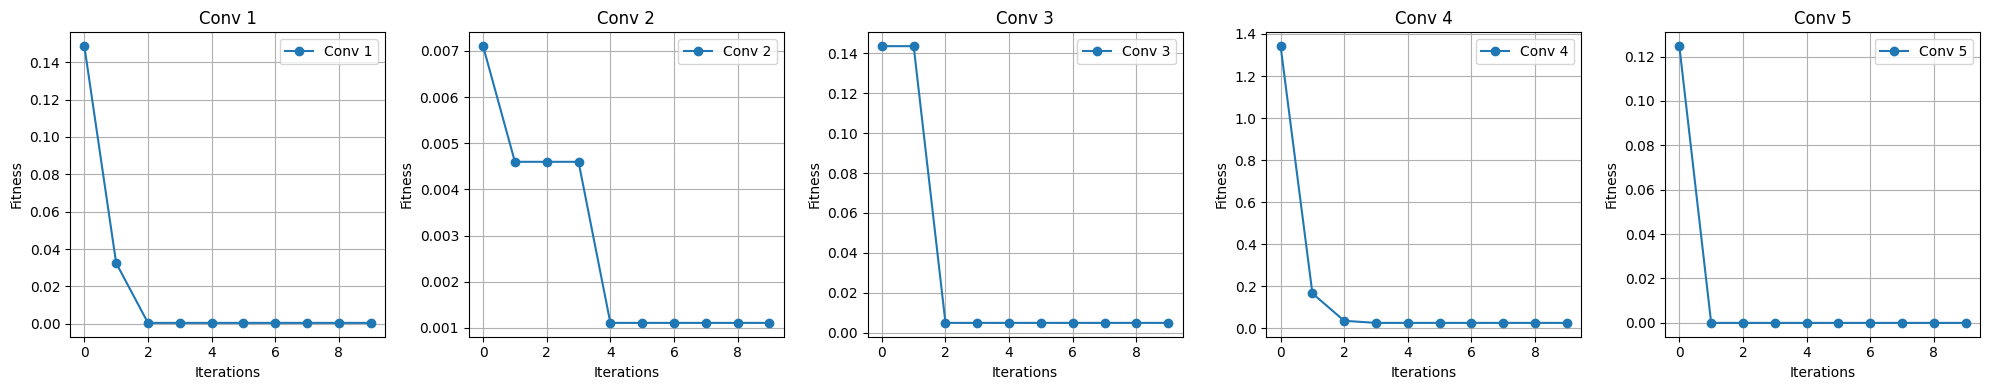

In [ ]:
#Convergence graphs for ORSO run 5 times for 500 iterations
import matplotlib.pyplot as plt
convfull = []
for _ in range(5):
    orso = OliveRidleySurvivalOptimizer(
    objective_function=sphere_function,
    num_turtles=30,
    dimensions=1,
    lower_bound=-10,
    upper_bound=10,
    max_iterations=10
    )
    _, _, convergence = orso.optimize()
    convfull.append(convergence)

plt.figure(figsize=(20, 4))  # Adjust width and height as needed
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.plot(convfull[i], marker='o', label=f'Conv {i + 1}')
  plt.xlabel('Iterations')
  plt.ylabel('Fitness')
  plt.title(f'Conv {i + 1}')
  plt.grid(True)
  plt.tight_layout()  # Prevent overlap
  plt.legend()
plt.show()

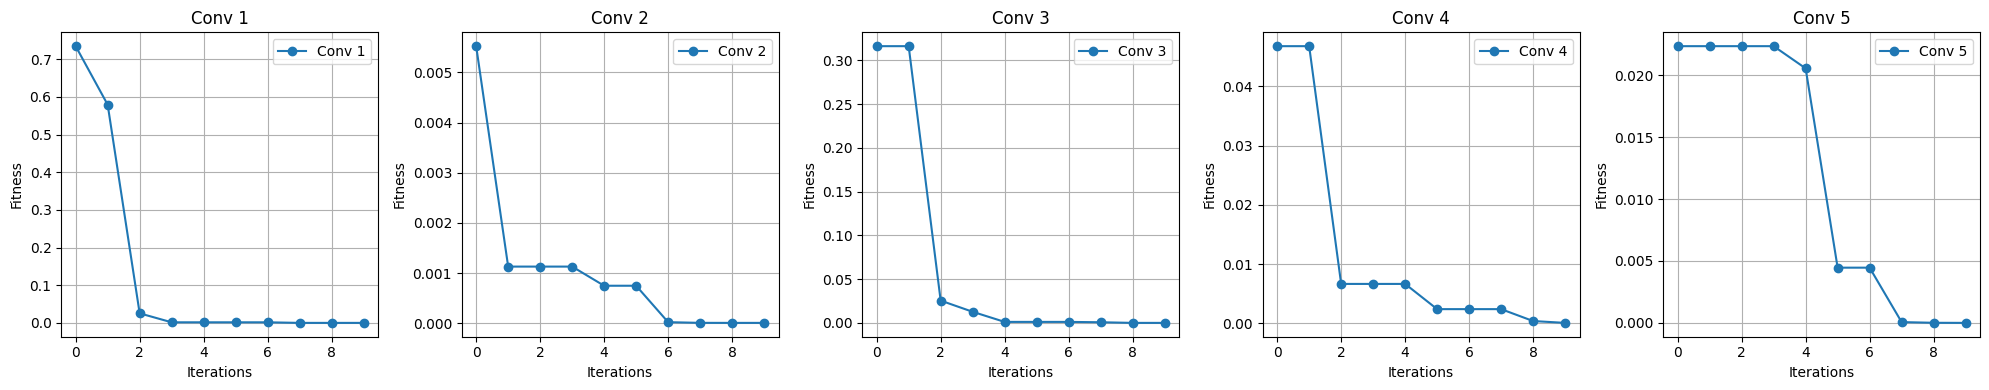

In [ ]:
#Convergence graphs for ORSO run 5 times for 500 iterations
import matplotlib.pyplot as plt
convfull = []
for _ in range(5):
    morso = ModifiedOliveRidleySurvivalOptimizer(
    objective_function=sphere_function,
    num_turtles=30,
    dimensions=1,
    lower_bound=-10,
    upper_bound=10,
    max_iterations=10
    )
    _, _, convergence = morso.optimize()
    convfull.append(convergence)

plt.figure(figsize=(20, 4))  # Adjust width and height as needed
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.plot(convfull[i], marker='o', label=f'Conv {i + 1}')
  plt.xlabel('Iterations')
  plt.ylabel('Fitness')
  plt.title(f'Conv {i + 1}')
  plt.grid(True)
  plt.tight_layout()  # Prevent overlap
  plt.legend()
plt.show()

In [ ]:
#Example:- Basic quadratic function nearly optimized in 10 iterations
def objective_function(x):
  return x[0]**2 + 3 * x[0] + 2
morso = ModifiedOliveRidleySurvivalOptimizer(
    objective_function=objective_function,
    num_turtles=30,
    dimensions=1,
    lower_bound=-10,
    upper_bound=10,
    max_iterations=10
)
best_x, best_fitness,convergence = morso.optimize()
print(f"Minimum value of the function is {best_fitness} at x = {best_x[0]}")

Minimum value of the function is -0.2496681525277813 at x = -1.4817833188473268


In [ ]:
#Making the list
import numpy as np
l1_original=[]
l2_modified=[]
# === 30 Benchmark Functions ===
functions_list = [
    lambda x: np.sum(x**2),
    lambda x: np.sum(np.abs(x)),
    lambda x: np.max(np.abs(x)),
    lambda x: np.sum(x**4),
    lambda x: np.sum(x**2 + 10*np.cos(2*np.pi*x)),
    lambda x: np.sum((x - 1)**2),
    lambda x: np.sum(np.cumsum(x)**2),
    lambda x: np.sum(np.abs(x) + x**2),
    lambda x: np.sum(np.sqrt(np.abs(x))),
    lambda x: np.sum(x**2 + 1),
    lambda x: np.sum((x + 2)**2),
    lambda x: np.sum(x**6),
    lambda x: np.sum(np.exp(x)),
    lambda x: np.sum(np.log(np.abs(x) + 1)),
    lambda x: np.sum(np.sin(x)**2),
    lambda x: np.sum(np.tanh(x)),
    lambda x: np.sum(x**2 + np.sin(x)),
    lambda x: np.sum(x**2 + np.cos(x)),
    lambda x: np.sum((x - 3)**2 + 2),
    lambda x: np.sum((x**2) * np.sin(x)),
    lambda x: np.sum(np.abs(x)**1.5),
    lambda x: np.sum(np.abs(x) + np.abs(x)**0.5),
    lambda x: np.sum(np.exp(-x**2)),
    lambda x: np.sum(np.cos(0.5 * x)),
    lambda x: np.sum(np.exp(np.abs(x)) - 1),
    lambda x: np.sum(x**3),
    lambda x: np.sum((x + 5)**2),
    lambda x: np.sum((x - 5)**2),
    lambda x: np.sum((x**2 + 3)**2),
    lambda x: np.sum(np.exp(-np.abs(x - 2)))
]

# === Evaluation Configuration ===
NUM_FUNCTIONS = len(functions_list)
RUNS_PER_FUNCTION = 50
EVALUATIONS_PER_RUN = 60000
POPULATION_SIZE = 2
DIMENSIONS = 5
ITERATIONS = 100
for i in range(RUNS_PER_FUNCTION):
  a=[]
  b=[]
  for f in functions_list:
    orso = OliveRidleySurvivalOptimizer(
    objective_function=f,
    dimensions=DIMENSIONS,
    max_iterations=ITERATIONS
    )
    best_solution, best_fitness,convergence = orso.optimize()
    a.append(best_fitness)
    morso = ModifiedOliveRidleySurvivalOptimizer(
    objective_function=f,
    dimensions=DIMENSIONS,
    max_iterations=ITERATIONS
    )
    best_solution, best_fitness, convergence = morso.optimize()
    b.append(best_fitness)
  l1_original.append(a)
  l2_modified.append(b)

# === Result Matrices ===
results_original = np.zeros((RUNS_PER_FUNCTION, NUM_FUNCTIONS))
results_optimized = np.zeros((RUNS_PER_FUNCTION, NUM_FUNCTIONS))

# === Evaluation Loop ===
for func_index, func in enumerate(functions_list):
    #print(f"\nEvaluating Function {func_index + 1}/{NUM_FUNCTIONS}")

    for run in range(RUNS_PER_FUNCTION):
        # --- Original ORSO ---
        orso_orig = OliveRidleySurvivalOptimizer(
            objective_function=func,
            dimensions=DIMENSIONS,
            max_iterations=ITERATIONS,
            num_turtles=POPULATION_SIZE,
            lower_bound=-5.12,
            upper_bound=5.12
        )
        _, best_fitness_orig,_ = orso_orig.optimize()
        results_original[run, func_index] = best_fitness_orig

        # --- Optimized ORSO ---
        orso_opt = ModifiedOliveRidleySurvivalOptimizer(
            objective_function=func,
            dimensions=DIMENSIONS,
            max_iterations=ITERATIONS,
            num_turtles=POPULATION_SIZE,
            lower_bound=-5.12,
            upper_bound=5.12
        )
        _, best_fitness_opt, _ = orso_opt.optimize()
        results_optimized[run, func_index] = best_fitness_opt

        #print(f"Run {run+1:02d} - Orig Fit: {best_fitness_orig:.4e}, Opt Fit: {best_fitness_opt:.4e}")


In [ ]:
#Printing the list
a1=np.array(l1_original)
a2=np.array(l2_modified)
print(a1)
print(a2)

[[3.11250605e+03 6.23452256e+01 4.17187068e+01 ... 4.52797842e+03
  3.78940378e+06 2.51728768e-44]
 [2.45890121e+03 6.84067393e+01 3.48005220e+01 ... 1.94689842e+03
  4.44523005e+06 2.51728768e-44]
 [5.08179315e+03 9.03142517e+01 2.49182343e+01 ... 3.83821596e+03
  5.01982335e+06 2.51728768e-44]
 ...
 [4.44056251e+03 1.08863375e+02 1.95177039e+01 ... 2.06567498e+03
  6.61213310e+05 2.51728768e-44]
 [3.80570344e+03 1.32532502e+02 3.00236402e+01 ... 2.54204664e+03
  1.68042378e+06 2.51728768e-44]
 [1.31645315e+03 9.14846065e+01 4.04839545e+01 ... 2.29503027e+03
  6.35227765e+06 2.51728768e-44]]
[[1.09285929e-04 3.48680945e-02 1.81643833e-02 ... 5.00971687e-04
  4.50083794e+01 8.34704653e-43]
 [3.99885346e-04 2.75795360e-02 1.36513063e-02 ... 4.53239932e-05
  4.50121952e+01 8.34704653e-43]
 [2.54562293e-04 7.42605541e-01 9.17708550e-03 ... 3.10312021e-04
  4.50021988e+01 1.37439250e-42]
 ...
 [1.59770789e-04 1.73642614e-02 1.45638008e-02 ... 2.61892562e-04
  4.50245407e+01 8.34704653e-43]

In [ ]:
#Wilcoxon Test
from scipy.stats import wilcoxon
import numpy as np

p_values = []
statistic_values = []

for i in range(results_original.shape[1]):
    orig = a1[:, i]
    opt = a2[:, i]
    diff = orig - opt

    # Skip if all differences are zero (no variation)
    if np.allclose(diff, 0):
        p_values.append(1.0)  # No significance
        statistic_values.append(0.0)
        print(f"Function {i+1:02d}: Skipped (no difference)")
        continue

    try:
        stat, p = wilcoxon(orig, opt, alternative='greater')
        p_values.append(p)
        statistic_values.append(stat)
    except ValueError as e:
        print(f"Function {i+1:02d}: Error: {e}")
        p_values.append(1.0)
        statistic_values.append(0.0)

# Display significant improvements
alpha = 0.05
print("\nSignificant Improvements (p < 0.05):")
for i, p in enumerate(p_values):
    if p < alpha:
        print(f"Function {i+1:02d}: p = {p:.4e}, Wilcoxon stat = {statistic_values[i]:.2f}")

Function 23: Skipped (no difference)
Function 30: Skipped (no difference)

Significant Improvements (p < 0.05):
Function 01: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 02: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 03: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 04: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 05: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 06: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 07: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 08: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 09: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 10: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 11: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 12: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 14: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 15: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 17: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 18: p = 8.8818e-16, Wilcoxon stat = 1275.00
Function 19: p = 8.8818e-16, Wilcoxon st

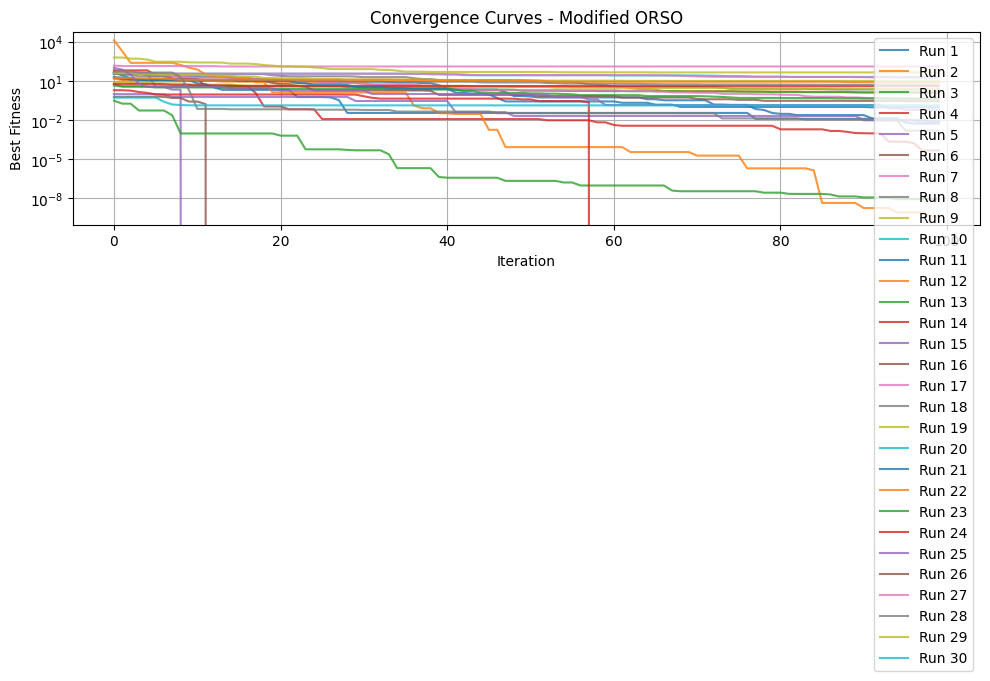

In [ ]:
#Convergence Graphs
convergence_data = {
    "original": [],
    "optimized": []
}

for run in range(30):
    # Optimized
    func = functions_list[run]
    morso = ModifiedOliveRidleySurvivalOptimizer(
        objective_function=func,
        dimensions=DIMENSIONS,
        max_iterations=ITERATIONS,
        num_turtles=POPULATION_SIZE,
        lower_bound=-5.12,
        upper_bound=5.12
    )
    _, _, conv_opt = morso.optimize()
    convergence_data["optimized"].append(conv_opt)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot each run's convergence curve
for i, conv in enumerate(convergence_data["optimized"]):
    plt.plot(conv, label=f'Run {i+1}', alpha=0.8)

plt.title('Convergence Curves - Modified ORSO')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.yscale('log')  # Optional: log scale if fitness drops exponentially
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Statistical Tests
fitness_original = []
fitness_modified = []
orso = OliveRidleySurvivalOptimizer(
        objective_function=sphere_function,
        dimensions=DIMENSIONS,
        max_iterations=ITERATIONS,
        num_turtles=POPULATION_SIZE,
        lower_bound=-5.12,
        upper_bound=5.12
)
for run in range(30):
    func = functions_list[run]
    orso = OliveRidleySurvivalOptimizer(
        objective_function=sphere_function,
        dimensions=DIMENSIONS,
        max_iterations=ITERATIONS,
        num_turtles=POPULATION_SIZE,
        lower_bound=-5.12,
        upper_bound=5.12
    )
    _, best_fit_orig,_ = orso.optimize()
    fitness_original.append(best_fit_orig)
    morso = ModifiedOliveRidleySurvivalOptimizer(
        objective_function=func,
        dimensions=DIMENSIONS,
        max_iterations=ITERATIONS,
        num_turtles=POPULATION_SIZE,
        lower_bound=-5.12,
        upper_bound=5.12
    )
    _, best_fit_orig,_ = morso.optimize()
    fitness_modified.append(best_fit_orig)
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

shapiro_orig = shapiro(fitness_original)
shapiro_mod = shapiro(fitness_modified)

print("Original ORSO Normality (p-value):", shapiro_orig.pvalue)
print("Modified ORSO Normality (p-value):", shapiro_mod.pvalue)

if shapiro_orig.pvalue > 0.05 and shapiro_mod.pvalue > 0.05:
    # Perform t-test
    t_test = ttest_ind(fitness_original, fitness_modified)
else:
  u_stat, p_val = mannwhitneyu(fitness_original, fitness_modified, alternative='two-sided')
  print("Mann-Whitney U Test p-value:", p_val)
def cohens_d(a, b):
    return (np.mean(a) - np.mean(b)) / np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)

print("Cohen's d:", cohens_d(fitness_original, fitness_modified))

Original ORSO Normality (p-value): 0.05549027850639716
Modified ORSO Normality (p-value): 2.057665994203646e-10
Mann-Whitney U Test p-value: 1.0665677738596446e-07
Cohen's d: 0.6384483717724738
